In [1]:
import numpy as np
import matplotlib.pyplot as plt
from camutils import Camera,triangulate, calibratePose, makerotation
import pickle
import visutils
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

***
# Calibration

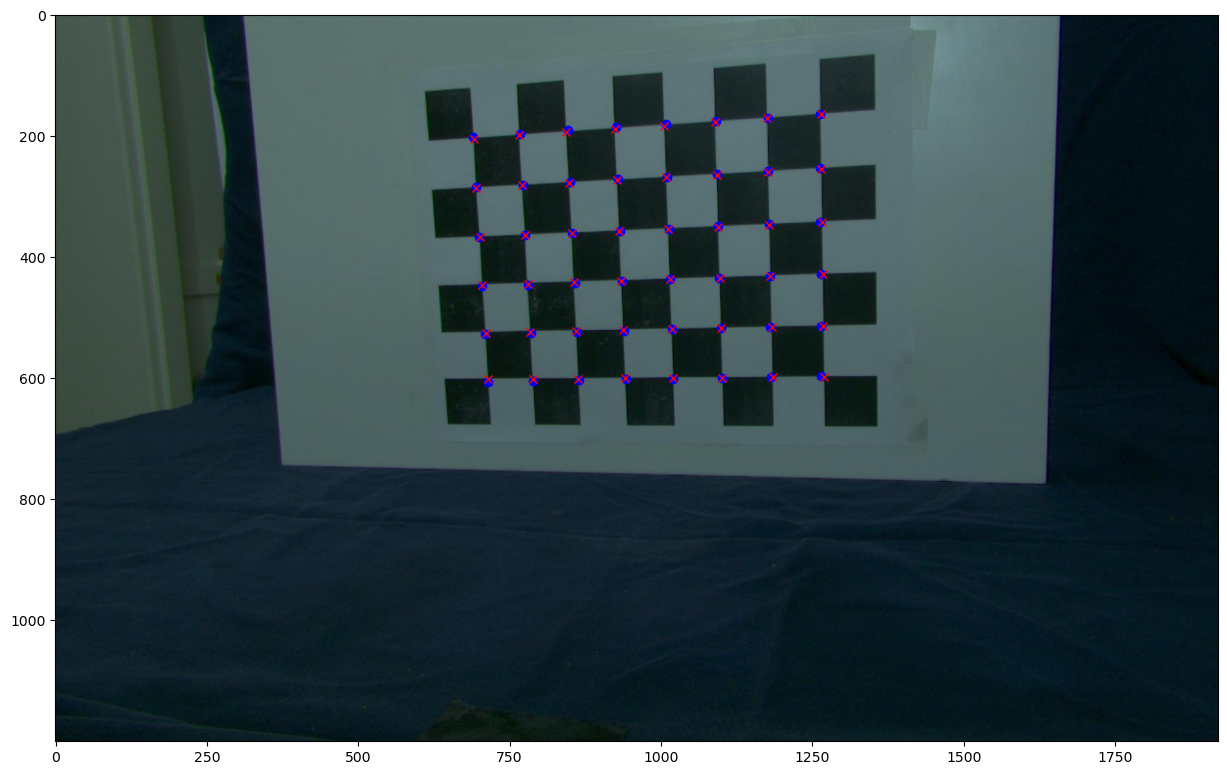

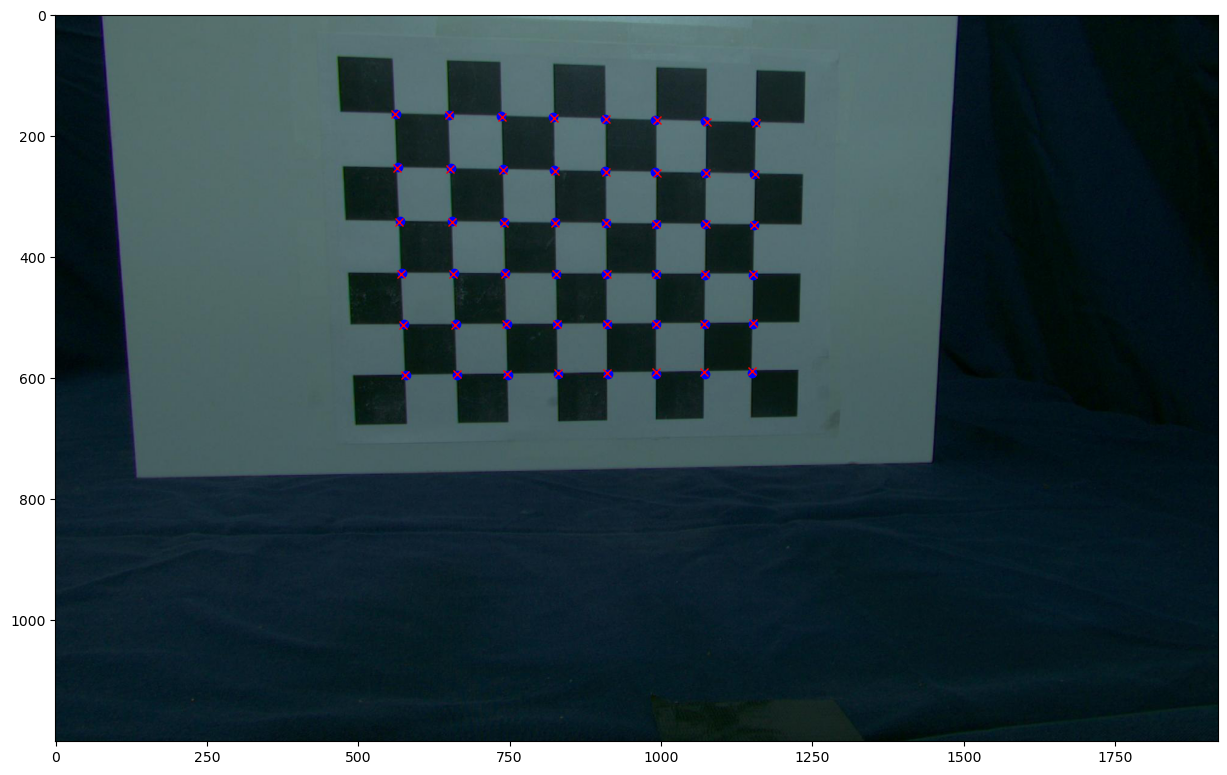

Camera : 
 f=1561.0139703220098 
 c=[[1021.14654024  755.83651806]] 
 R=[[ 2.91696327e-02  9.85750215e-01  1.65667276e-01]
 [ 9.85196756e-01 -3.42860395e-04 -1.71427053e-01]
 [-1.68927453e-01  1.68215327e-01 -9.71167915e-01]] 
 t = [[10.32164264 20.55954625 53.7559705 ]]
Camera : 
 f=1561.0139703220098 
 c=[[1021.14654024  755.83651806]] 
 R=[[ 0.00274182  0.99134284  0.13127015]
 [ 0.99345347 -0.01769207  0.11285917]
 [ 0.11420457  0.13010134 -0.9849015 ]] 
 t = [[12.50679948  8.76902665 54.25921734]]
12.001854864413506
0.3133195263729998
0.1415162222635128
Average error: -0.006834388879540693
The average error of my recovered 3D locations of the grid corner points relative to their true coordinates is: 0.3133195263729998 cm
0.13265102754999408


In [3]:
import cv2

# load in the intrinsic camera parameters

fid = open('calibration.pickle','rb')
calib = pickle.load(fid)
fid.close()

# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
getf  =(calib["fx"]+calib["fy"])/2
camL = Camera(f=getf,c=np.array([[calib["cx"],calib["cy"]]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
camR = Camera(f=getf,c=np.array([[calib["cx"],calib["cy"]]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread("C:/Users/allye/Desktop/UCI/cs117/Final Project/calib_jpg_u/frame_C0_01.jpg")
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread("C:/Users/allye/Desktop/UCI/cs117/Final Project/calib_jpg_u/frame_C1_01.jpg")
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
# you need to modify this code to take into account that the 
# squares are 2.8cm x 2.8cm 
pts3 = np.zeros((3,6*8))
xx,yy = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*yy.reshape(1,-1)
pts3[1,:] = 2.8*xx.reshape(1,-1)


# Now use your calibratePose function to get the extrinsic parameters
# for the two images. You may need to experiment with the initialization
# in order to get a good result
paramsL_init = np.array([0,-1,0,0,0,-1])
paramsR_init = np.array([0,-1,0,0,0,-1])

camL = calibratePose(pts3,pts2L,camL,paramsL_init)
camR = calibratePose(pts3,pts2R,camR,paramsR_init)

# Finally, triangulate the checkerboard points based on the estimated camera pose
pts3r = triangulate(pts2L,camL,pts2R,camR)

# Display the reprojected points overlayed on the images
plt.rcParams['figure.figsize']=[15,15]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()

print(camL)
print(camR)
print(np.sqrt(np.sum((camL.t-camR.t)*(camL.t-camR.t))))

print(np.mean(np.sqrt(np.sum((pts3r-pts3)*(pts3r-pts3),axis=0))))

print(np.mean(np.sum((pts3r-pts3)*(pts3r-pts3),axis=0)))
print("Average error:", np.average(pts3 - pts3r))
print(f'The average error of my recovered 3D locations of the grid corner points relative to their true coordinates is: {np.mean(np.sqrt(np.sum((pts3r-pts3)*(pts3r-pts3),axis=0)))} cm')
print(np.mean(np.absolute(pts3r - pts3)))

***
#  Reconstruction

In [4]:
def decode(imprefix,start,threshold, color_imprefix, color_threshold):
    """
 
    Parameters
    ----------
    imprefix : str
   
    start : int

    threshold : float

    Returns
    -------
    code : 2D numpy.array (dtype=float)
        
    mask : 2D numpy.array (dtype=float)
    
    
    """
    nbits = 10
    
    imgs = list()
    imgs_inv = list()
    print('loading',end='')
    for i in range(start,start+2*nbits,2):
        fname0 = '%s%2.2d.png' % (imprefix,i)
        fname1 = '%s%2.2d.png' % (imprefix,i+1)
        print('(',i,i+1,')',end='')
        img = plt.imread(fname0)
        img_inv = plt.imread(fname1)
        if (img.dtype == np.uint8):
            img = img.astype(float) / 256
            img_inv = img_inv.astype(float) / 256
        if (len(img.shape)>2):
            img = np.mean(img,axis=2)
            img_inv = np.mean(img_inv,axis=2)
        imgs.append(img)
        imgs_inv.append(img_inv)
        
    (h,w) = imgs[0].shape
    print('\n')
    
    gcd = np.zeros((h,w,nbits))
    mask = np.ones((h,w))
    for i in range(nbits):
        gcd[:,:,i] = imgs[i]>imgs_inv[i]
        mask = mask * (np.abs(imgs[i]-imgs_inv[i])>threshold)
        
    bcd = np.zeros((h,w,nbits))
    bcd[:,:,0] = gcd[:,:,0]
    for i in range(1,nbits):
        bcd[:,:,i] = np.logical_xor(bcd[:,:,i-1],gcd[:,:,i])
        
    code = np.zeros((h,w))
    for i in range(nbits):
        code = code + np.power(2,(nbits-i-1))*bcd[:,:,i]
        
    colorimage1 = '%s%2.2d.png' % (color_imprefix,0)
    colorimage2 = '%s%2.2d.png' % (color_imprefix,1)
    color1 = plt.imread(colorimage1)
    color2 = plt.imread(colorimage2)
    colormask = np.ones((h,w))
    #comparing colors based on squared Euclidean distance can be a way to quantify the difference between colors
    colormask = colormask *((np.sum(np.square(color1-color2), axis=-1))>color_threshold)
    return code,mask, colormask

In [5]:
def reconstruct(imprefixL,imprefixR,threshold,camL,camR, color_imprefixL, color_imprefixR, color_threshold):
    """

    Parameters
    ----------
    imprefix : str

    threshold : float

    camL,camR : Camera

    Returns
    -------
    pts2L,pts2R : 2D numpy.array (dtype=float)

    pts3 : 2D numpy.array (dtype=float)

    """

    CLh,maskLh, colormaskL = decode(imprefixL,0,threshold,color_imprefixL, color_threshold)
    CLv,maskLv,_ = decode(imprefixL,20,threshold,color_imprefixL, color_threshold)
    CRh,maskRh, colormaskR = decode(imprefixR,0,threshold,color_imprefixR, color_threshold)
    CRv,maskRv,_ = decode(imprefixR,20,threshold, color_imprefixR, color_threshold)

    CL = CLh + 1024*CLv
    maskL = maskLh*maskLv*colormaskL
    CR = CRh + 1024*CRv
    maskR = maskRh*maskRv*colormaskR

    h = CR.shape[0]
    w = CR.shape[1]

    subR = np.nonzero(maskR.flatten())
    subL = np.nonzero(maskL.flatten())

    CRgood = CR.flatten()[subR]
    CLgood = CL.flatten()[subL]

    _,submatchR,submatchL = np.intersect1d(CRgood,CLgood,return_indices=True)

    matchR = subR[0][submatchR]
    matchL = subL[0][submatchL]

    xx,yy = np.meshgrid(range(w),range(h))
    xx = np.reshape(xx,(-1,1))
    yy = np.reshape(yy,(-1,1))

    pts2R = np.concatenate((xx[matchR].T,yy[matchR].T),axis=0)
    pts2L = np.concatenate((xx[matchL].T,yy[matchL].T),axis=0)

    pts3 = triangulate(pts2L,camL,pts2R,camR)
    #get color from pts2R and pts2L
    colorsL=[]
    colorsR=[]
    colorimage1 = '%s%2.2d.png' % (color_imprefixL,1)
    colorimage2 = '%s%2.2d.png' % (color_imprefixR,1)
    colorvalueL = plt.imread(colorimage1)
    colorvalueR = plt.imread(colorimage2)
    #pts2L consists of pixels that belong to the object
    #so use pts2L to get the RGB values, Same as pts2R
    for i in range(pts2L.shape[1]):
        colorsL.append(colorvalueL[pts2L[1][i]][pts2L[0][i]])
        colorsR.append(colorvalueR[pts2R[1][i]][pts2R[0][i]])
    #turn list into arrays
    pixelvL = np.array(colorsL) 
    pixelvR = np.array(colorsR) 
    #print(pixelvL.shape)
    avgcolors = (pixelvL+pixelvL)/2
    #print(avgcolors.shape)
    pixelv = avgcolors.T
    #print(pixelv.shape)
    
    return pts2L,pts2R,pts3, pixelv

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )



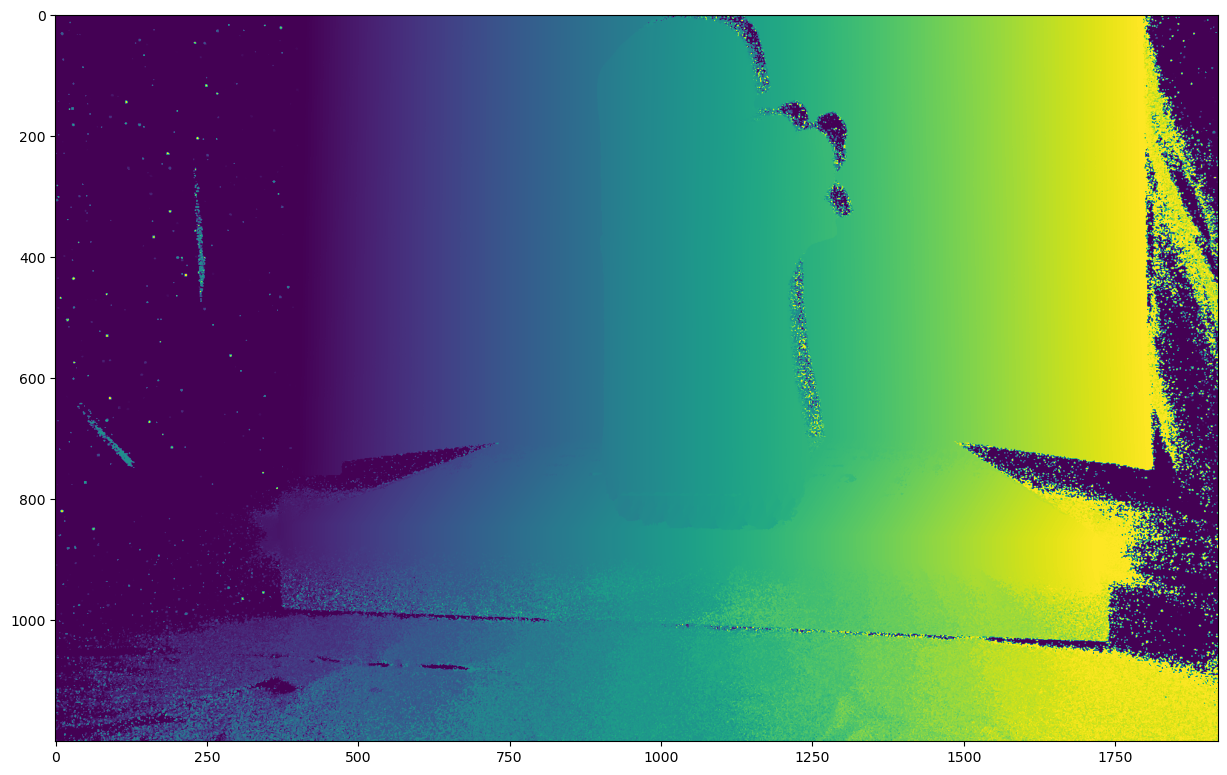

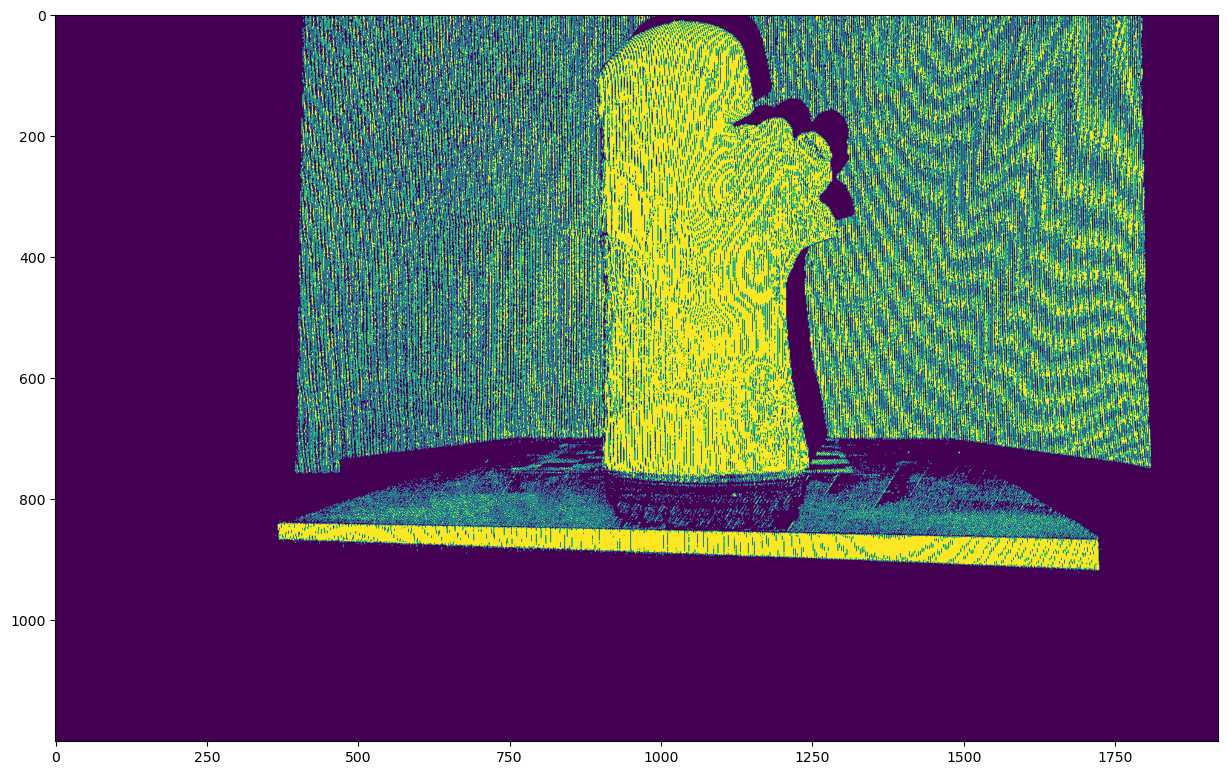

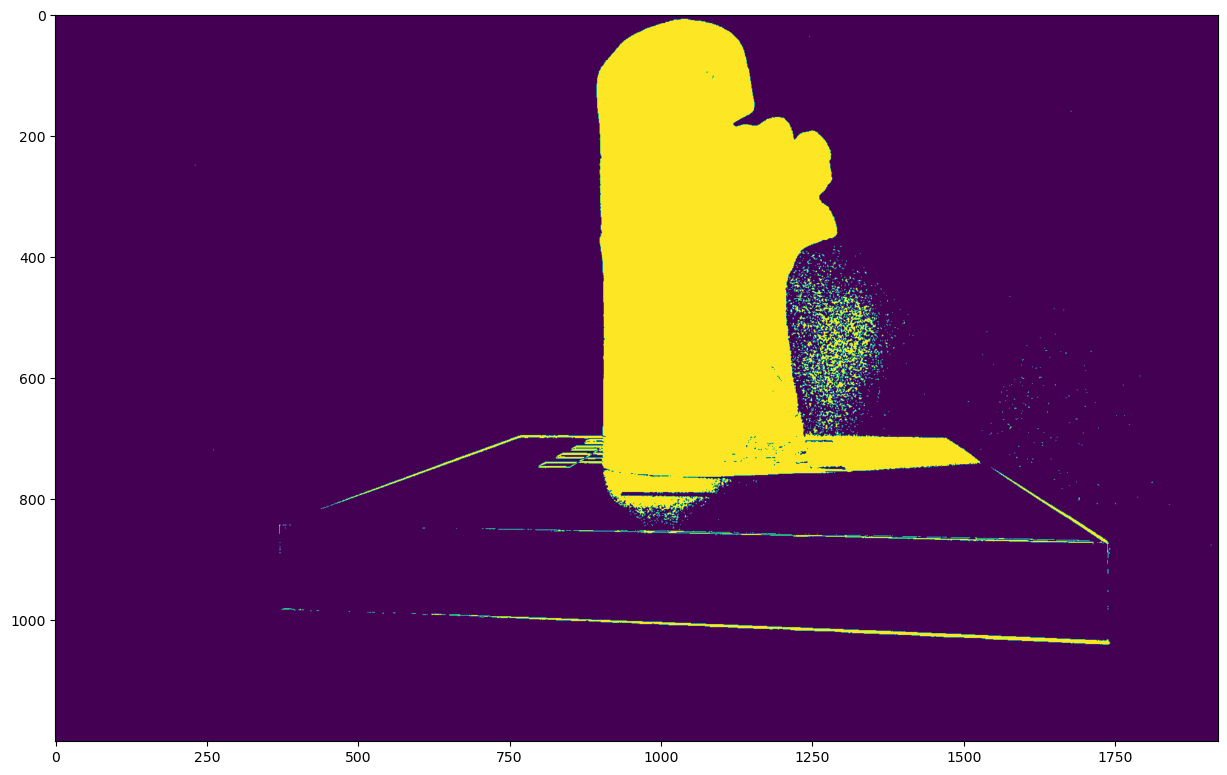

(<matplotlib.image.AxesImage at 0x19fd702b790>, None)

In [6]:
thresh = 0.02
color_thresh=0.01
code,mask, colormask = decode('C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_0_u/frame_C0_',0,thresh,\
                  'C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_0_u/color_C0_',color_thresh )

plt.rcParams['figure.figsize']=[15,15]
plt.imshow(code), plt.show()
plt.imshow(mask), plt.show()
plt.imshow(colormask), plt.show()

In [7]:
def visualize(pts3, camL, camR):
    # Add your visualization code here.  As we have done previously it is good to visualize different
    # 2D projections XY, XZ, YZ and well as a 3D version

    # generate coordinates of a line segment running from the center
    # of the camera to 2 units in front of the camera

    lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,50]]).T))
    lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,50]]).T))

    #visualize 3D layout of points, camera positions
    # and the direction the camera is pointing
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(2,2,1,projection='3d')
    ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
    ax.plot(camR.t[0],camR.t[1],camR.t[2],'ro')
    ax.plot(camL.t[0],camL.t[1],camL.t[2],'bo')
    ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
    ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
    ax.set_xlim3d([-20,40])
    ax.set_ylim3d([-20,40])
    ax.set_zlim3d([-40,20])
    visutils.label_axes(ax)
    plt.title('scene 3D view')

    ax = fig.add_subplot(2,2,2)
    ax.plot(pts3[0,:],pts3[2,:],'.')
    ax.plot(camL.t[0],camL.t[2],'bo')
    ax.plot(lookL[0,:],lookL[2,:],'b')
    ax.plot(camR.t[0],camR.t[2],'ro')
    ax.plot(lookR[0,:],lookR[2,:],'r')
    plt.axis([-20, 40, -50, 50])
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('XZ-view')

    ax = fig.add_subplot(2,2,3)
    ax.plot(pts3[1,:],pts3[2,:],'.')
    ax.plot(camL.t[1],camL.t[2],'bo')
    ax.plot(lookL[1,:],lookL[2,:],'b')
    ax.plot(camR.t[1],camR.t[2],'ro')
    ax.plot(lookR[1,:],lookR[2,:],'r')
    plt.axis([-10, 30, -60, 20])
    plt.grid()
    plt.xlabel('y')
    plt.ylabel('z')
    plt.title('YZ-view')

    ax = fig.add_subplot(2,2,4)
    ax.plot(pts3[0,:],pts3[1,:],'.')
    ax.plot(camL.t[0],camL.t[1],'bo')
    ax.plot(lookL[0,:],lookL[1,:],'b')
    ax.plot(camR.t[0],camR.t[1],'ro')
    ax.plot(lookR[0,:],lookR[1,:],'r')
    plt.axis([ -25,25 ,30,-10 ])
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('XY-view')

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



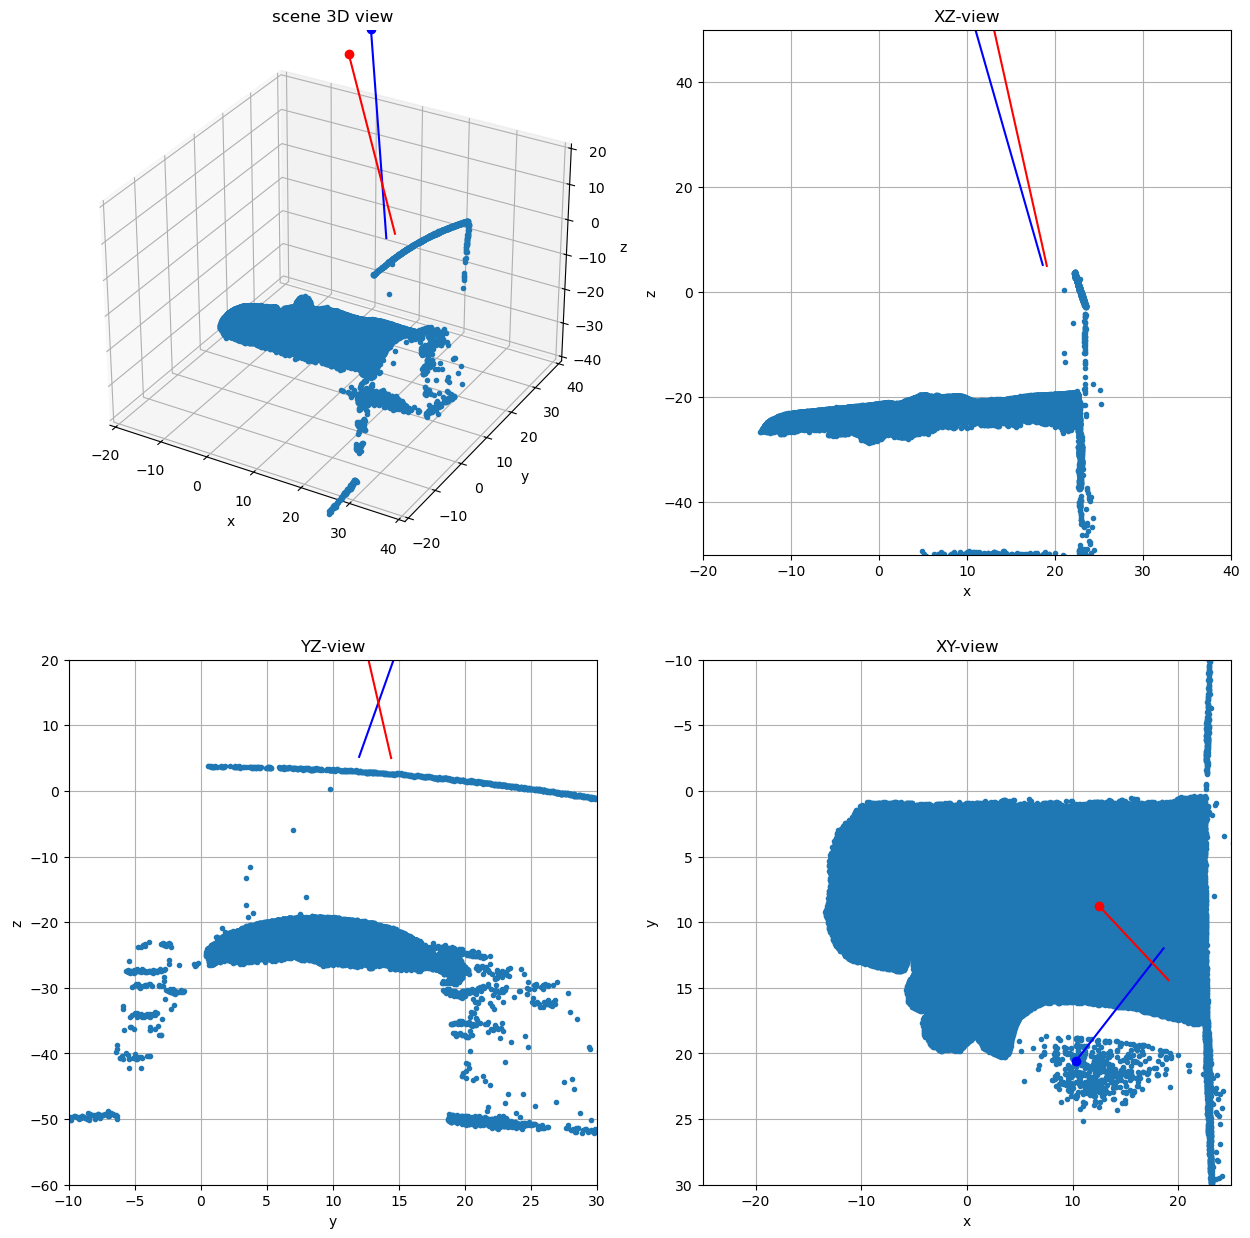

In [8]:
imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_0_u/frame_C0_"
imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_0_u/frame_C1_"
color_imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_0_u/color_C0_"
color_imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_0_u/color_C1_"
threshold = 0.01
color_threshold = 0.01

pts2L,pts2R,pts3, pixelv = reconstruct(imprefixL,imprefixR,threshold,camL,camR, color_imprefixL, color_imprefixR, color_threshold)
visualize(pts3, camL,camR)

# Mesh

In [10]:
def getmesh(pts2L,pts2R,pts3,blim,trithresh, pixelv):
    from scipy.spatial import Delaunay
    #
    # drop points which are outside the bounding box
    #
    goodpts = np.nonzero((pts3[0,:]>blim[0])& (pts3[0,:]<blim[1]) & \
                      (pts3[1,:]>blim[2])&(pts3[1,:]<blim[3])& \
                      (pts3[2,:]>blim[4])&(pts3[2,:]<blim[5])) 

    pts3 = pts3[:,goodpts[0]]
    pts2L = pts2L[:,goodpts[0]]
    pts2R = pts2R[:,goodpts[0]]
    pixelv = pixelv[:,goodpts[0]]

    #
    # compute initial triangulation
    #
    Triangles = Delaunay(pts2L.T)
    tri = Triangles.simplices
    #neighbor smoothing
    def getneighbors(index, triang):
        return triang.vertex_neighbor_vertices[1]\
        [triang.vertex_neighbor_vertices[0][index]:triang.vertex_neighbor_vertices[0][index+1]]
    
    for x in range (pts3.shape[1]):
        pts3[:,x] = np.mean(pts3[:,getneighbors(x,Triangles)],axis=1)    
    for x in range (pts3.shape[1]):
        pts3[:,x] = np.mean(pts3[:,getneighbors(x,Triangles)],axis=1)
    for x in range (pts3.shape[1]):
        pts3[:,x] = np.mean(pts3[:,getneighbors(x,Triangles)],axis=1)    
    

    d01 = np.sqrt(np.sum(np.power(pts3[:,tri[:,0]]-pts3[:,tri[:,1]],2),axis=0))
    d02 = np.sqrt(np.sum(np.power(pts3[:,tri[:,0]]-pts3[:,tri[:,2]],2),axis=0))
    d12 = np.sqrt(np.sum(np.power(pts3[:,tri[:,1]]-pts3[:,tri[:,2]],2),axis=0))

    goodtri = (d01<trithresh)&(d02<trithresh)&(d12<trithresh)

    tri = tri[goodtri,:]


    tokeep = np.unique(tri)
    remap = np.zeros(pts3.shape[1],dtype='int')
    remap[tokeep]= np.arange(0,tokeep.shape[0])
    pts3 = pts3[:,tokeep]
    pixelv = pixelv[:,tokeep]
    tri = remap[tri]
    return pts2L, pts2R, pts3, tri, pixelv

In [11]:

# Mesh cleanup parameters

# Specify limits along the x,y and z axis of a box containing the object
# we will prune out triangulated points outside these limits
blim = np.array([-15,25,0, 20.5,-29,-19])

# Specify a longest allowed edge that can appear in the mesh. Remove triangles
# from the final mesh that have edges longer than this value
trithresh = 0.3
pts2L, pts2R, pts3, tri , pixelv = getmesh(pts2L,pts2R,pts3,blim,trithresh, pixelv)

# Visualize again after cleaning

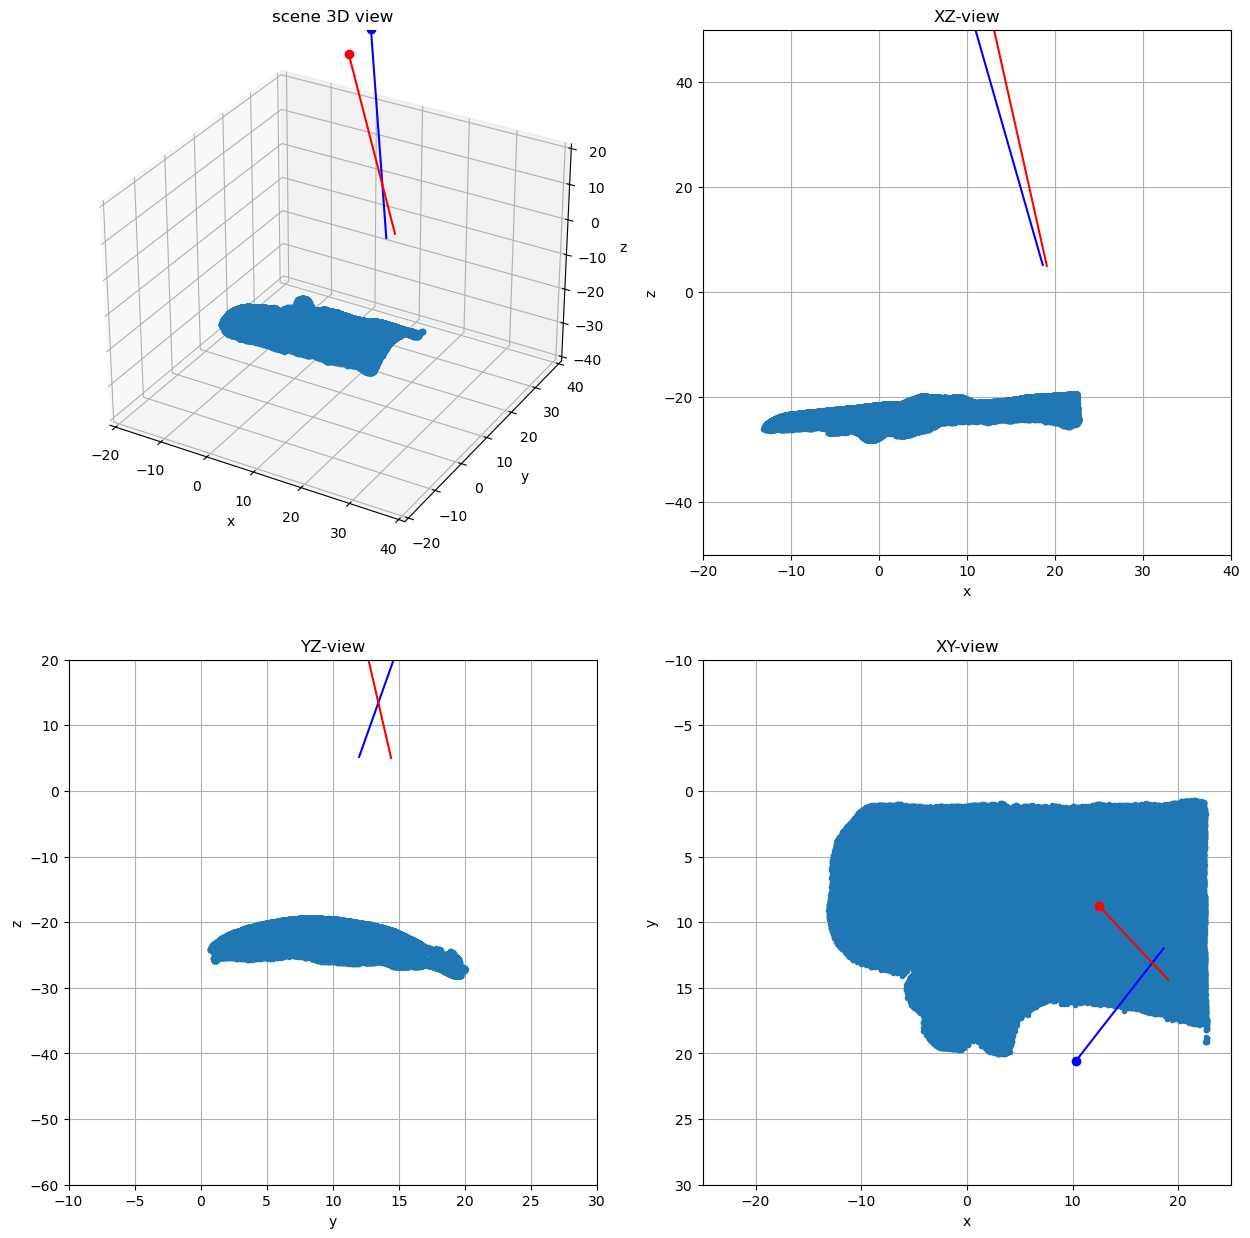

In [12]:
visualize(pts3, camL, camR)

In [13]:
def writeply(X,color,tri,filename):
    """
    Save out a triangulated mesh to a ply file
    
    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        vertex coordinates shape (3,Nvert)
        
    color : 2D numpy.array (dtype=float)
        vertex colors shape (3,Nvert)
        
    tri : 2D numpy.array (dtype=float)
        triangular faces shape (Ntri,3)
        
    filename : string
        filename to save to    
    """
    f = open(filename,"w");
    f.write('ply\n');
    f.write('format ascii 1.0\n');
    f.write('element vertex %i\n' % X.shape[1]);
    f.write('property float x\n');
    f.write('property float y\n');
    f.write('property float z\n');
    f.write('property uchar red\n');
    f.write('property uchar green\n');
    f.write('property uchar blue\n');
    f.write('element face %d\n' % tri.shape[0]);
    f.write('property list uchar int vertex_indices\n');
    f.write('end_header\n');

    C = (255*color).astype('uint8')
    i = 0
    
    for i in range(X.shape[1]):
        f.write('%f %f %f %i %i %i\n' % (X[0,i],X[1,i],X[2,i],C[0,i],C[1,i],C[2,i]));
    
    for t in range(tri.shape[0]):
        f.write('3 %d %d %d\n' % (tri[t,1],tri[t,0],tri[t,2]))

    f.close();


# Use writeply function to generate ply

In [14]:
#need to fix color later
#color = np.random.random(size=pts3.shape)
writeply(pts3,pixelv,tri,'grab_0.ply')
#it workkkkkkkkkksksksks!

In [15]:
#Do other 5 grab files
imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_1_u/frame_C0_"
imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_1_u/frame_C1_"
color_imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_1_u/color_C0_"
color_imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_1_u/color_C1_"
threshold = 0.002
color_threshold = 0.005
pts2L,pts2R,pts3, pixelv = reconstruct(imprefixL,imprefixR,threshold,camL,camR, color_imprefixL, color_imprefixR, color_threshold)
#visualize(pts3, camL, camR)
blim = np.array([-13,25,4.5,18,-28,-12])
trithresh = 1.3
pts2L, pts2R, pts3, tri, pixelv = getmesh(pts2L,pts2R,pts3,blim,trithresh, pixelv)
#visualize(pts3, camL, camR)
writeply(pts3,pixelv,tri,'grab_1.ply')

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



In [16]:
imprefixL = "C:/Users/allye/Desktop/UCI/cs117/final Project/couple/grab_2_u/frame_C0_"
imprefixR = "C:/Users/allye/Desktop/UCI/cs117/final Project/couple/grab_2_u/frame_C1_"
color_imprefixL = "C:/Users/allye/Desktop/UCI/cs117/final Project/couple/grab_2_u/color_C0_"
color_imprefixR = "C:/Users/allye/Desktop/UCI/cs117/final Project/couple/grab_2_u/color_C1_"
threshold = 0.005
color_threshold = 0.01
pts2L,pts2R,pts3, pixelv = reconstruct(imprefixL,imprefixR,threshold,camL,camR, color_imprefixL, color_imprefixR, color_threshold)
#visualize(pts3, camL, camR)
blim = np.array([-13,25,3.5,19,-29,-13.5])
trithresh = 1
pts2L, pts2R, pts3, tri, pixelv = getmesh(pts2L,pts2R,pts3,blim,trithresh, pixelv)
#visualize(pts3, camL, camR)
writeply(pts3, pixelv,tri,'grab_2.ply')

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



In [17]:
#writeply(pts3,color,tri,'grab_2.ply')

imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_3_u/frame_C0_"
imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_3_u/frame_C1_"
color_imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_3_u/color_C0_"
color_imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_3_u/color_C1_"
threshold = 0.005
color_threshold = 0.01
pts2L,pts2R,pts3, pixelv = reconstruct(imprefixL,imprefixR,threshold,camL,camR, color_imprefixL, color_imprefixR, color_threshold)
#visualize(pts3, camL, camR)
blim = np.array([-13,25,-2,18,-28,-15])
trithresh = 0.4
pts2L, pts2R, pts3, tri, pixelv = getmesh(pts2L,pts2R,pts3,blim,trithresh, pixelv)
#visualize(pts3, camL, camR)
writeply(pts3, pixelv,tri,'grab_3.ply')



loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



In [18]:
imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_4_u/frame_C0_"
imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_4_u/frame_C1_"
color_imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_4_u/color_C0_"
color_imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_4_u/color_C1_"
threshold = 0.005
color_threshold = 0.01
pts2L,pts2R,pts3, pixelv = reconstruct(imprefixL,imprefixR,threshold,camL,camR, color_imprefixL, color_imprefixR, color_threshold)
#visualize(pts3, camL, camR)
blim = np.array([-11,25,6,18,-25,-11.5])
trithresh = 1.4
pts2L, pts2R, pts3, tri, pixelv = getmesh(pts2L,pts2R,pts3,blim,trithresh, pixelv)
color = np.random.random(size=pts3.shape)
#visualize(pts3, camL, camR)
writeply(pts3, pixelv,tri,'grab_4.ply')

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )



In [19]:

imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_6_u/frame_C0_"
imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_6_u/frame_C1_"
color_imprefixL = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_6_u/color_C0_"
color_imprefixR = "C:/Users/allye/Desktop/UCI/cs117/Final Project/couple/grab_6_u/color_C1_"
threshold = 0.001
color_threshold = 0.01
pts2L,pts2R,pts3, pixelv = reconstruct(imprefixL,imprefixR,threshold,camL,camR, color_imprefixL, color_imprefixR, color_threshold)
#visualize(pts3, camL, camR)
blim = np.array([12,22.5,-8,22,-43,-3])
trithresh = 1
pts2L, pts2R, pts3, tri, pixelv  = getmesh(pts2L,pts2R,pts3,blim,trithresh, pixelv)
#visualize(pts3, camL, camR)
writeply(pts3,pixelv,tri,'grab_6.ply')

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

